<h1>Agent-Agent Tests</h1>

We need to run agent vs agent tests, instead of just baseline vs baseline. These will allow us to actually evaluate if the agents are behaving in an expected way, or if there is a framework we need to develop to evaluate potential 'tacit collusion'. 

To be scientifically rigorous, we need to be able to run the algorithm in each setting multiple times and compare the results. Due to the cost asymmetry guarantee, we need to run the algorithm in each setting.

### imports

In [1]:
import sys, os 
import numpy as np
sys.path.append(os.path.abspath(".."))
from market_core import DuopolyEnv 
import matplotlib.pyplot as plt
import seaborn as sns
from utils import run_episode, plot_generalized_convergence, plot_market_shares, plot_price_gap
from agent_zoo import NSRAgent, FixedPriceAgent, RandomAgent, RLAgent

## Static Market

In [2]:
env_config = {
    'market_mode': 'static',
    'production_costs': [1.0, 2.0],
    'quality': [5.0, 5.0],
    'price_sensitivity': 0.8, # Back to standard sensitivity
    'max_price': 8.0,
    'cost_std': 0.0,
    'max_steps': 10000
} 
nsr_config_1 = {
    'n_bins': 100,
    'learning_rate': 0.01,
    'quality': 5.0,           # Must match env
    'price_sensitivity': 0.8, # Must match env
    'cost': 1.0               # Agent 1's cost
}
nsr_config_2 = {
    'n_bins': 100,
    'learning_rate': 0.01,
    'quality': 5.0,           # Must match env
    'price_sensitivity': 0.8, # Must match env
    'cost': 2.0               # Agent 2's cost
}
rl_config = {
    'state_dim': 5,          # Dimension of observation space (must match env)
    'hidden_dim': 128,        # Neural network hidden size
    'n_bins': 100,           # Number of discrete price actions
    'lr': 5e-5,              # Learning rate
    'gamma': 0.99,           # Discount factor
    'epsilon': 1.0,          # Initial exploration rate
    'epsilon_decay': 0.995,  # Exploration decay per step
    'epsilon_min': 0.01,     # Minimum exploration rate
    'batch_size': 64,        # Training batch size
    'memory_size': 2000,     # Replay buffer size
}

In [3]:
env = DuopolyEnv(env_config)

/Users/alanwu/Documents/GitHub/cis-6200-final/venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/alanwu/Documents/GitHub/cis-6200-final/venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


### NSR vs NSR

In [4]:
nsr_1 = NSRAgent(env.action_space, config=nsr_config_1)
nsr_2 = NSRAgent(env.action_space, config=nsr_config_2)

In [5]:
nsr_nsr = run_episode(env, nsr_1, nsr_2, label="NSR vs NSR", train_mode=True)

In [7]:
print("Average price of NSR vs NSR (Agent 1):", np.mean(nsr_nsr['p1'][-100:]))
print("Average price of NSR vs NSR (Agent 2):", np.mean(nsr_nsr['p2'][-100:]))

Average price of NSR vs NSR (Agent 1): 3.7171707
Average price of NSR vs NSR (Agent 2): 4.0404043


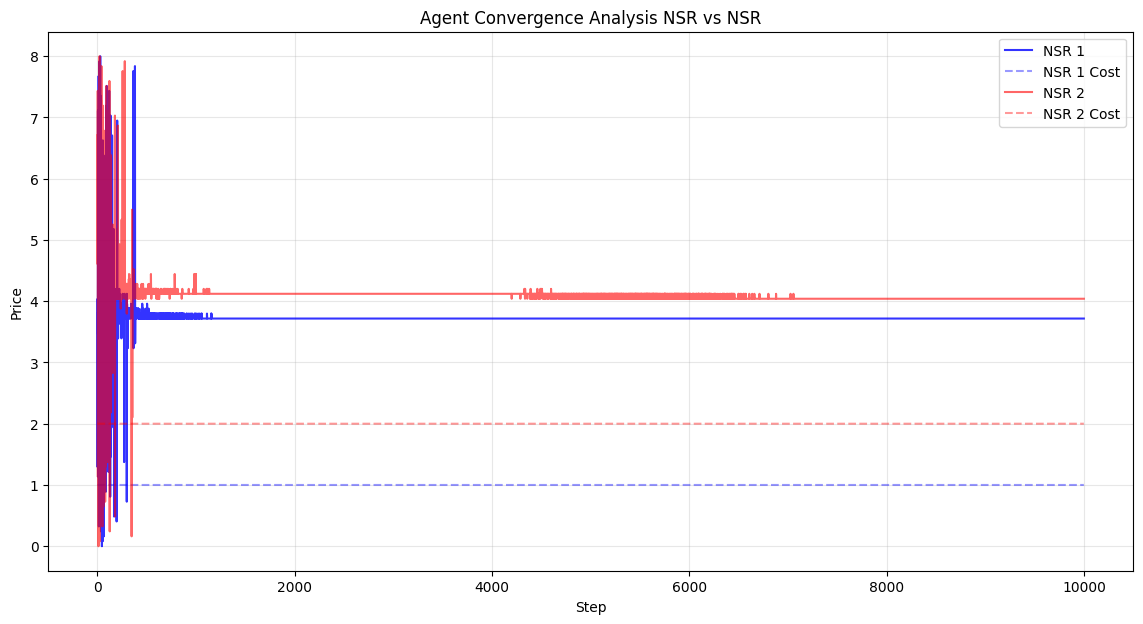

In [9]:
plot_generalized_convergence(nsr_nsr, env_config, title_suffix="NSR vs NSR", agent_1_label="NSR 1", agent_2_label="NSR 2", plot_br1 = False, plot_br2 = False)

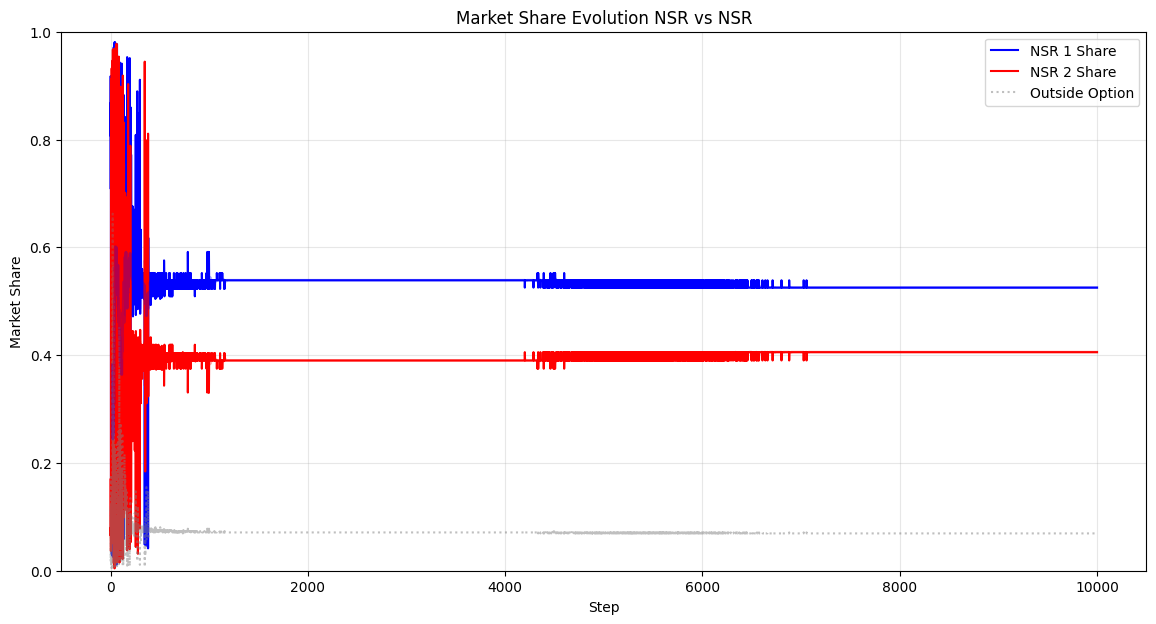

In [11]:
plot_market_shares(nsr_nsr, env_config, title_suffix="NSR vs NSR", agent_1_label="NSR 1", agent_2_label="NSR 2")

### NSR vs RL

In this scenario, the NSR agent is the low cost firm, and the RL Agent is the high cost firm. NSR is agent 1, RL is agent 2

In [12]:
rl_agent = RLAgent(action_space=env.action_space, config=rl_config)
nsr_1.reset()

In [13]:
nsr_rl_tr = run_episode(env, nsr_1, rl_agent, label="NSR vs RL", train_mode=True)
nsr_rl_ts = run_episode(env, nsr_1, rl_agent, label="NSR vs RL", train_mode=False)

In [14]:
print("Average price of NSR (Agent 1):", np.mean(nsr_rl_ts['p1'][-100:]))
print("Average price of RL (Agent 2):", np.mean(nsr_rl_ts['p2'][-100:]))

Average price of NSR (Agent 1): 3.9595957
Average price of RL (Agent 2): 4.60606


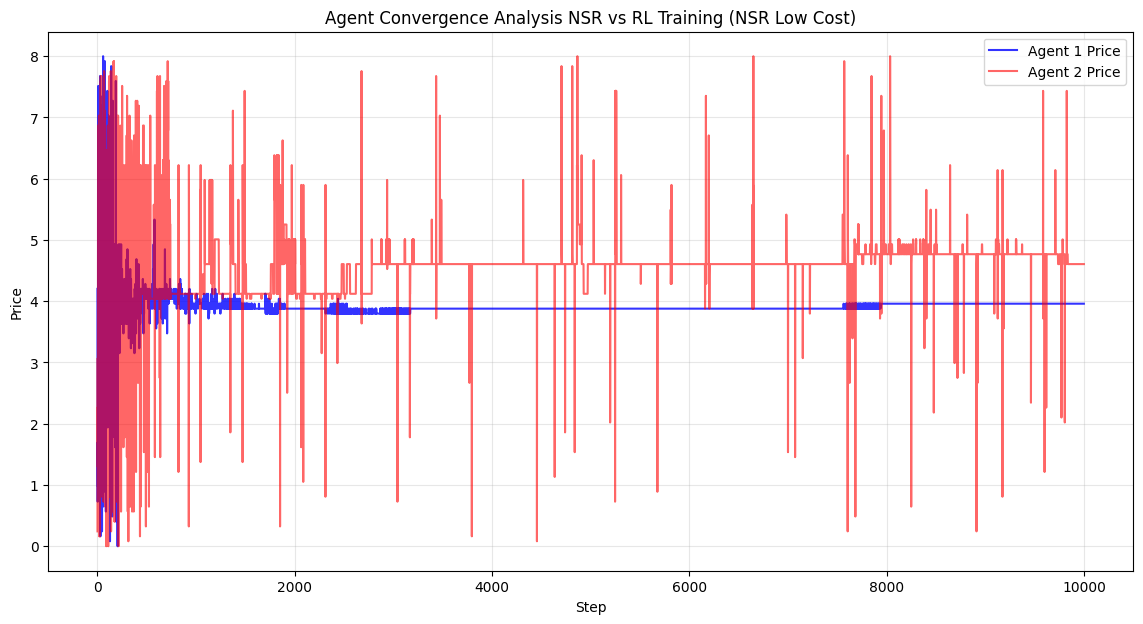

In [ ]:
plot_generalized_convergence(nsr_rl_tr, env_config, title_suffix="NSR vs RL Training (NSR Low Cost)", agent_1_label="NSR Agent", agent_2_label="RL Agent", plot_br1 = False, plot_br2 = False)

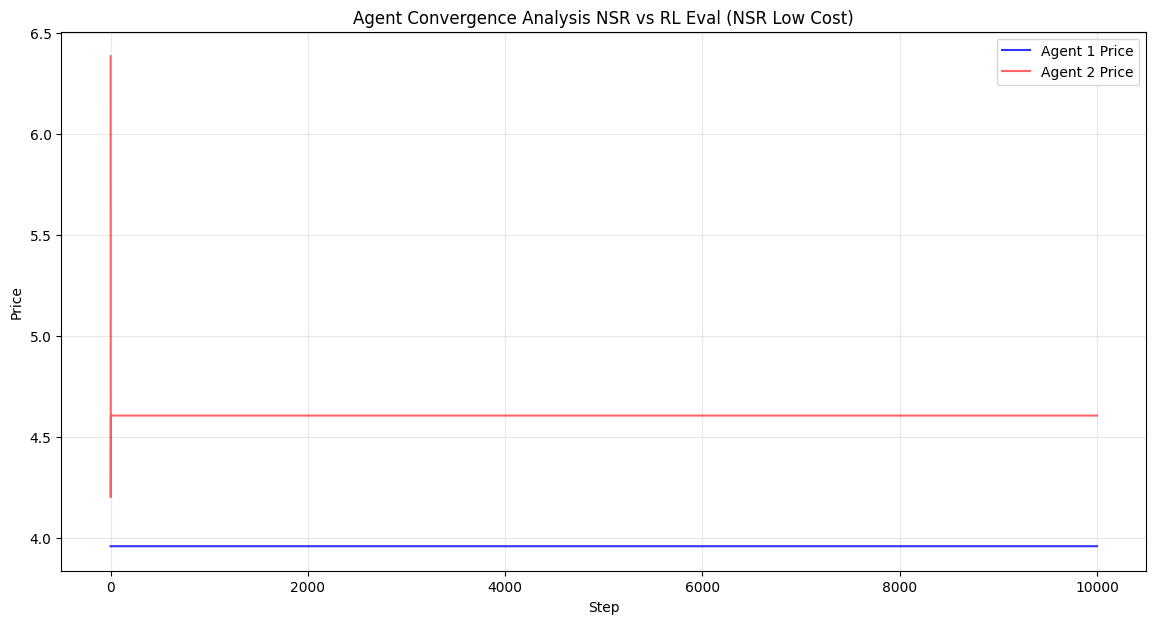

In [24]:
plot_generalized_convergence(nsr_rl_ts, env_config, title_suffix="NSR vs RL Eval (NSR Low Cost)", plot_br1 = False, plot_br2 = False)

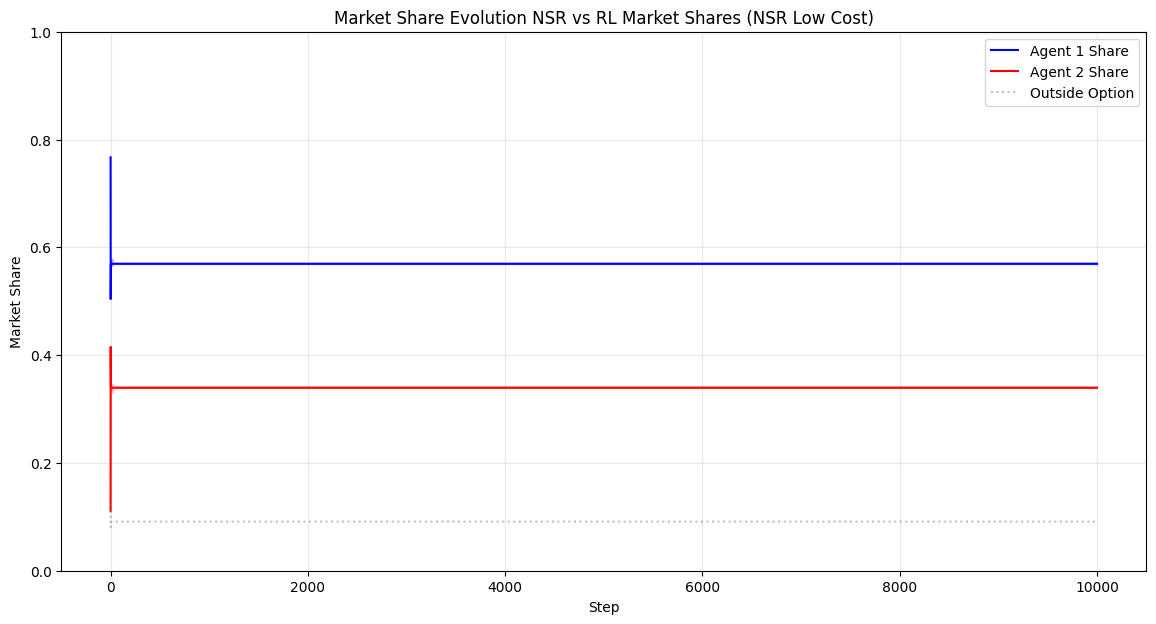

In [25]:
plot_market_shares(nsr_rl_ts, env_config, title_suffix="NSR vs RL Market Shares (NSR Low Cost)")

### RL vs NSR 

In this scenario, the RL agent is the low cost firm, and the NSR Agent is the high cost firm. RL is agent 1, NSR is agent 2

In [20]:
nsr_2.reset() 
rl_agent.reset()

In [21]:
rl_nsr_tr = run_episode(env, rl_agent, nsr_2, label="NSR vs RL", train_mode=True)
rl_nsr_ts = run_episode(env, rl_agent, nsr_2, label="NSR vs RL", train_mode=False)

In [28]:
print("Average price of RL (Agent 1):", np.mean(rl_nsr_ts['p1'][-100:]))
print("Average price of NSR (Agent 2):", np.mean(rl_nsr_ts['p2'][-100:]))

Average price of RL (Agent 1): 4.4040403
Average price of NSR (Agent 2): 4.363637


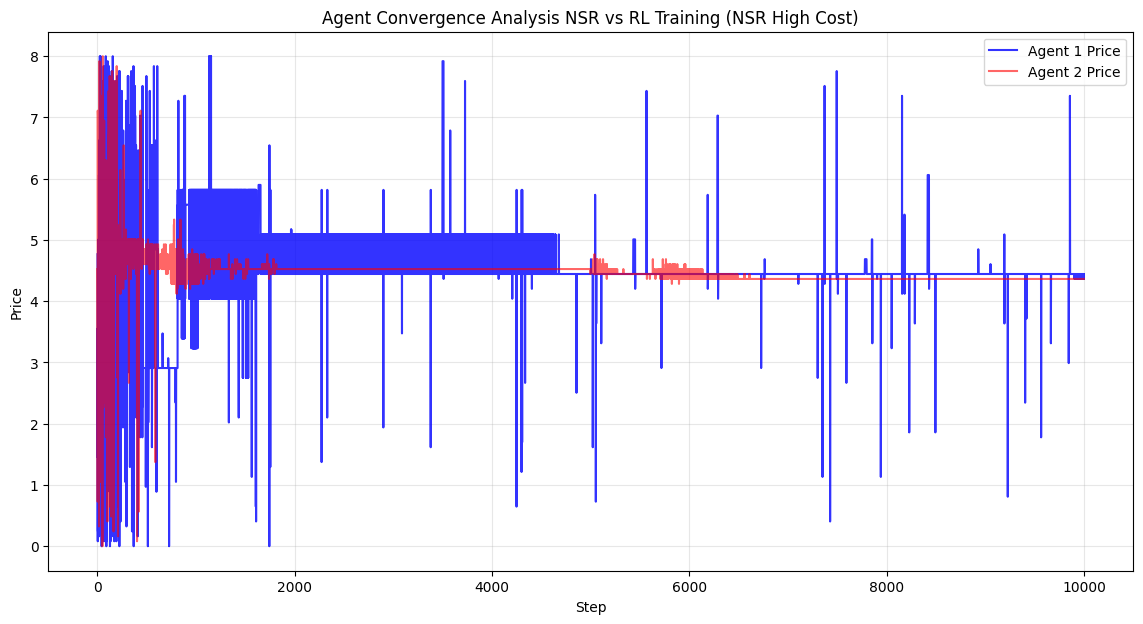

In [26]:
plot_generalized_convergence(rl_nsr_tr, env_config, title_suffix="NSR vs RL Training (NSR High Cost)", plot_br1 = False, plot_br2 = False)

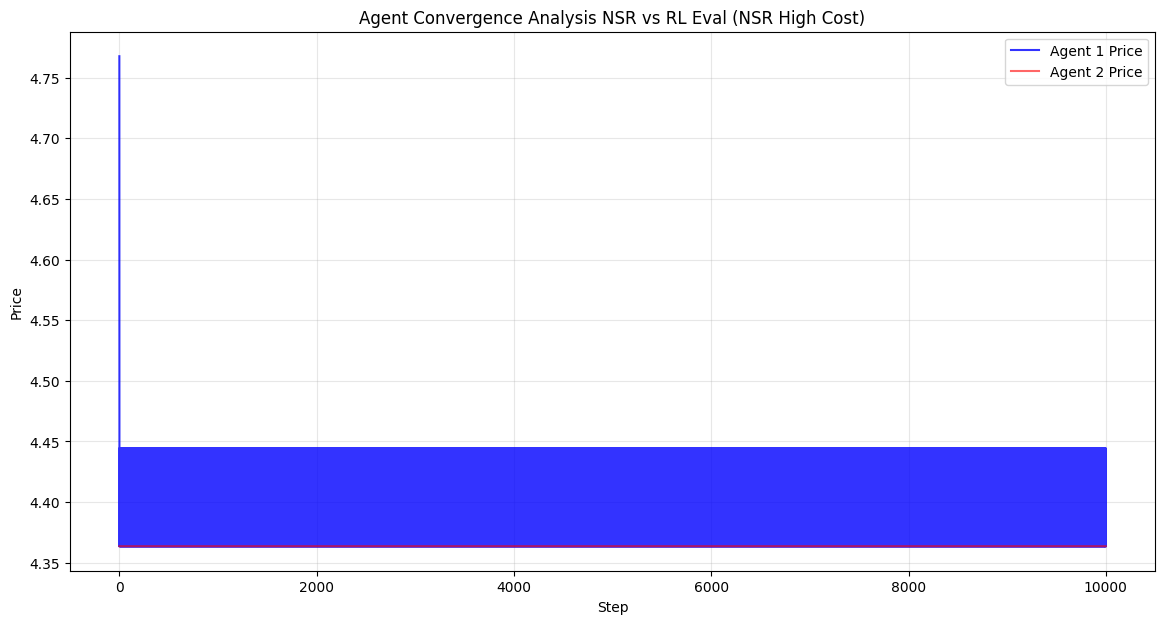

In [27]:
plot_generalized_convergence(rl_nsr_ts, env_config, title_suffix="NSR vs RL Eval (NSR High Cost)", plot_br1 = False, plot_br2 = False)

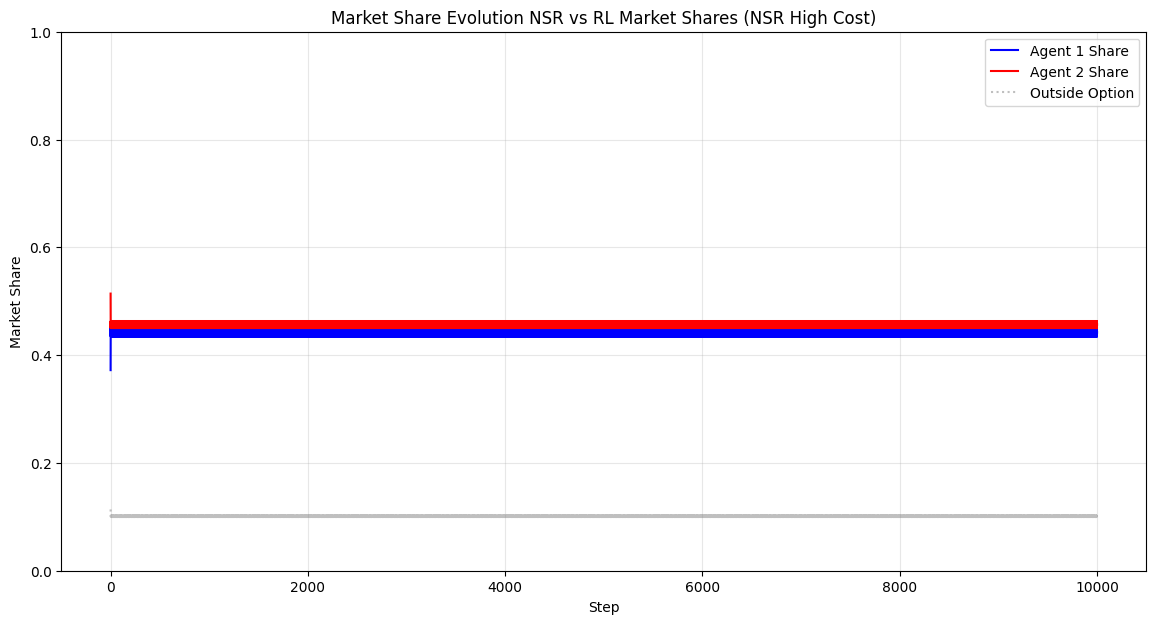

In [31]:
plot_market_shares(rl_nsr_ts, env_config, title_suffix="NSR vs RL Market Shares (NSR High Cost)")

### RL vs RL 

In [39]:
rl_1 = RLAgent(action_space=env.action_space, config=rl_config)
rl_2 = RLAgent(action_space=env.action_space, config=rl_config)

In [40]:
rl_rl_tr = run_episode(env, rl_1, rl_2, label="RL vs RL", train_mode=True)
rl_rl_ts = run_episode(env, rl_1, rl_2, label="RL vs RL", train_mode=False)

In [41]:
print("Average price of RL (Agent 1):", np.mean(rl_rl_ts['p1'][-100:]))
print("Average price of RL (Agent 2):", np.mean(rl_rl_ts['p2'][-100:]))

Average price of RL (Agent 1): 4.2828293
Average price of RL (Agent 2): 5.333332


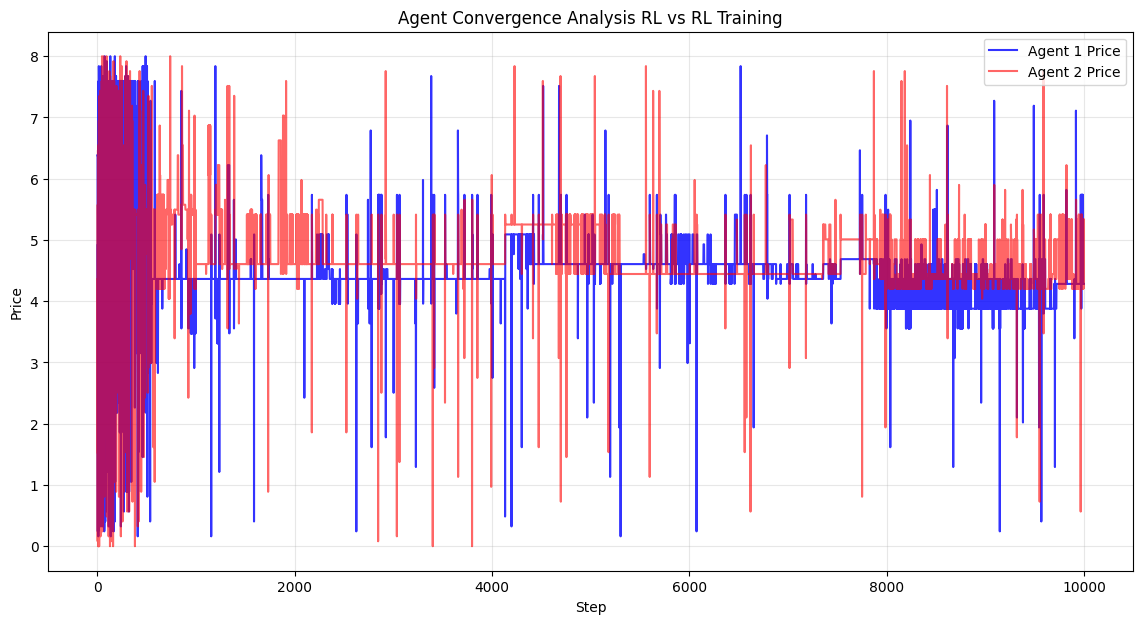

In [42]:
plot_generalized_convergence(rl_rl_tr, env_config, title_suffix="RL vs RL Training", plot_br1 = False, plot_br2 = False)

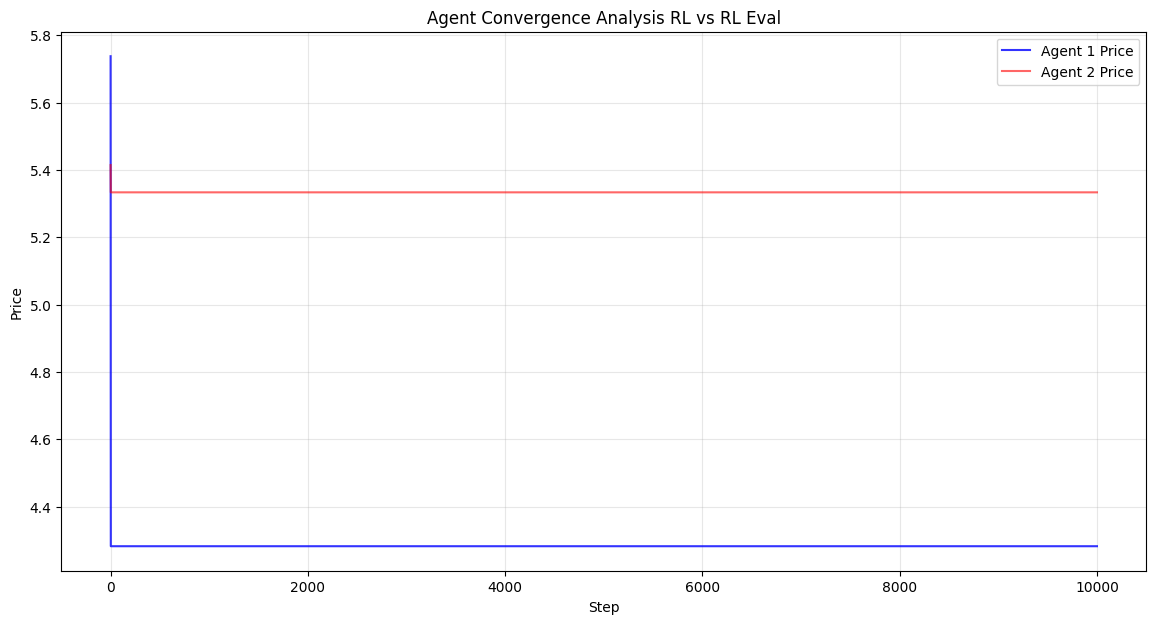

In [43]:
plot_generalized_convergence(rl_rl_ts, env_config, title_suffix="RL vs RL Eval", plot_br1 = False, plot_br2 = False)

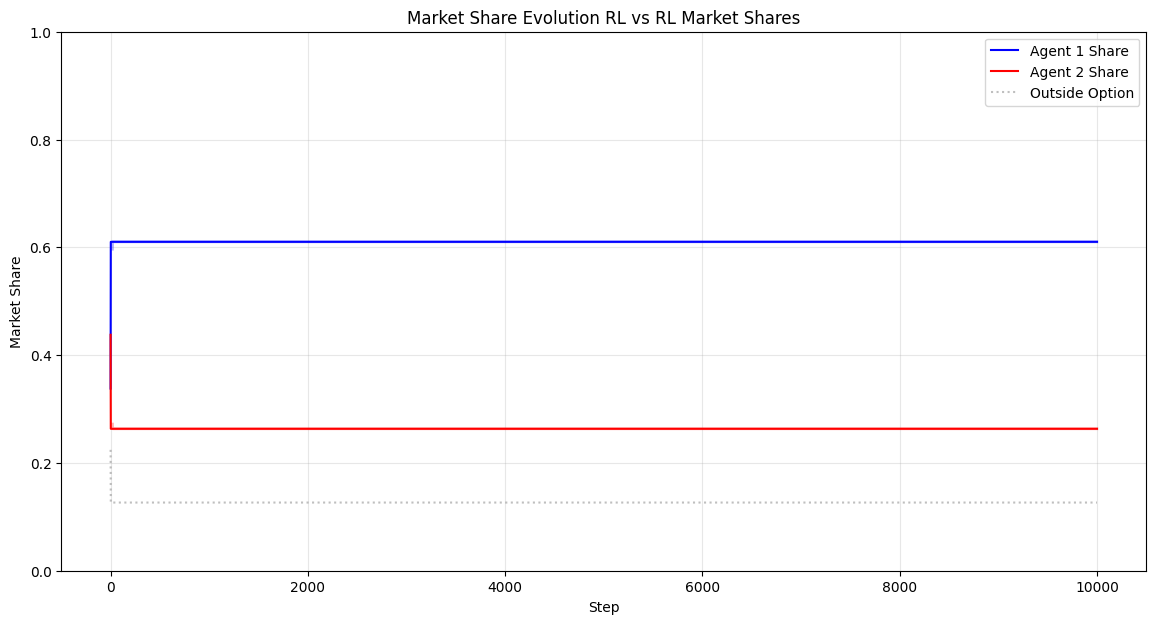

In [44]:
plot_market_shares(rl_rl_ts, env_config, title_suffix="RL vs RL Market Shares")

## Dynamic Market (AR(1))

We add demand shock to the environment to simulate market momentum. 

In [3]:
env_config = {
    'market_mode': 'ar_drift',
    'production_costs': [1.0, 2.0],
    'quality': [5.0, 5.0],
    'price_sensitivity': 0.8, # Back to standard sensitivity
    'max_price': 8.0,
    'cost_std': 0.0,
    'max_steps': 10000, 
    'demand_shock_mean': 0.0,
    'demand_shock_std': 0.2,
    'demand_shock_phi': 0.8 # High persistence
} 
nsr_config_1 = {
    'n_bins': 100,
    'learning_rate': 0.01,
    'quality': 5.0,           # Must match env
    'price_sensitivity': 0.8, # Must match env
    'cost': 1.0               # Agent 1's cost
}
nsr_config_2 = {
    'n_bins': 100,
    'learning_rate': 0.01,
    'quality': 5.0,           # Must match env
    'price_sensitivity': 0.8, # Must match env
    'cost': 2.0               # Agent 2's cost
}
rl_config = {
    'state_dim': 5,          # Dimension of observation space (must match env)
    'hidden_dim': 128,        # Neural network hidden size
    'n_bins': 100,           # Number of discrete price actions
    'lr': 5e-5,              # Learning rate
    'gamma': 0.99,           # Discount factor
    'epsilon': 1.0,          # Initial exploration rate
    'epsilon_decay': 0.995,  # Exploration decay per step
    'epsilon_min': 0.01,     # Minimum exploration rate
    'batch_size': 64,        # Training batch size
    'memory_size': 2000,     # Replay buffer size
}

In [4]:
env = DuopolyEnv(env_config)

/Users/alanwu/Documents/GitHub/cis-6200-final/venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/alanwu/Documents/GitHub/cis-6200-final/venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


### NSR vs NSR

In [5]:
nsr_1 = NSRAgent(action_space=env.action_space, config=nsr_config_1)
nsr_2 = NSRAgent(action_space=env.action_space, config=nsr_config_2)

In [6]:
nsr_nsr_ar = run_episode(env, nsr_1, nsr_2, label="NSR vs NSR AR", train_mode=True)

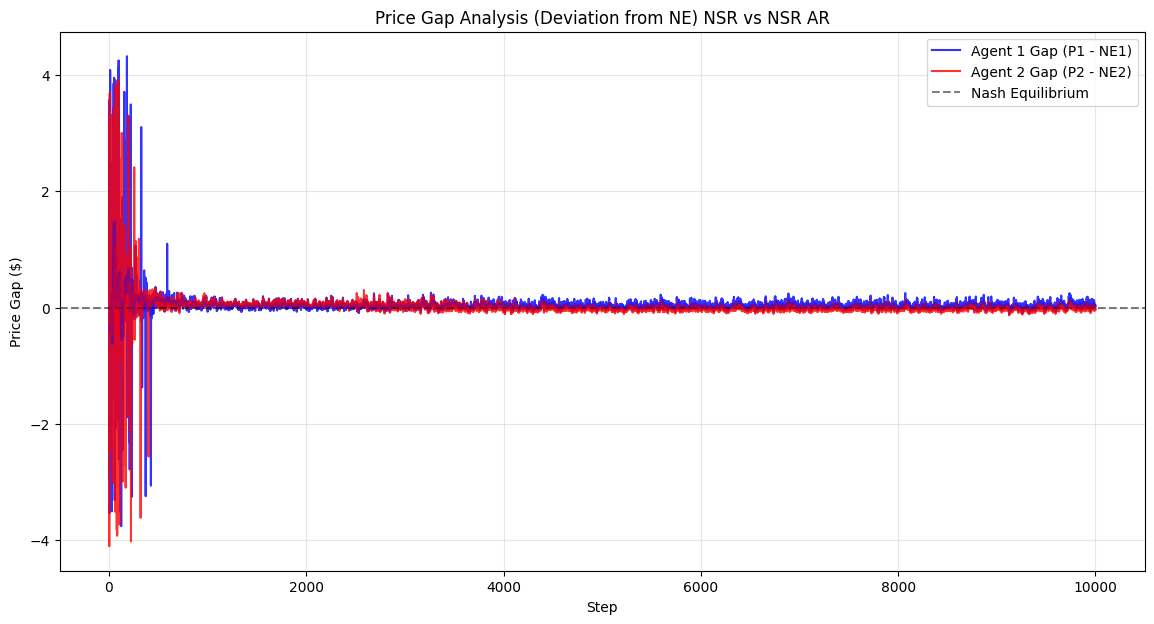

In [7]:
plot_price_gap(nsr_nsr_ar, env_config, title_suffix="NSR vs NSR AR")

### NSR vs RL

In [8]:
rl_agent = RLAgent(action_space=env.action_space, config=rl_config)
nsr_1.reset()

In [11]:
rl_nsr_ar_tr = run_episode(env, nsr_1, rl_agent, label="NSR vs RL", train_mode=True)
rl_nsr_ar_ts = run_episode(env, nsr_1, rl_agent, label="NSR vs RL", train_mode=False)

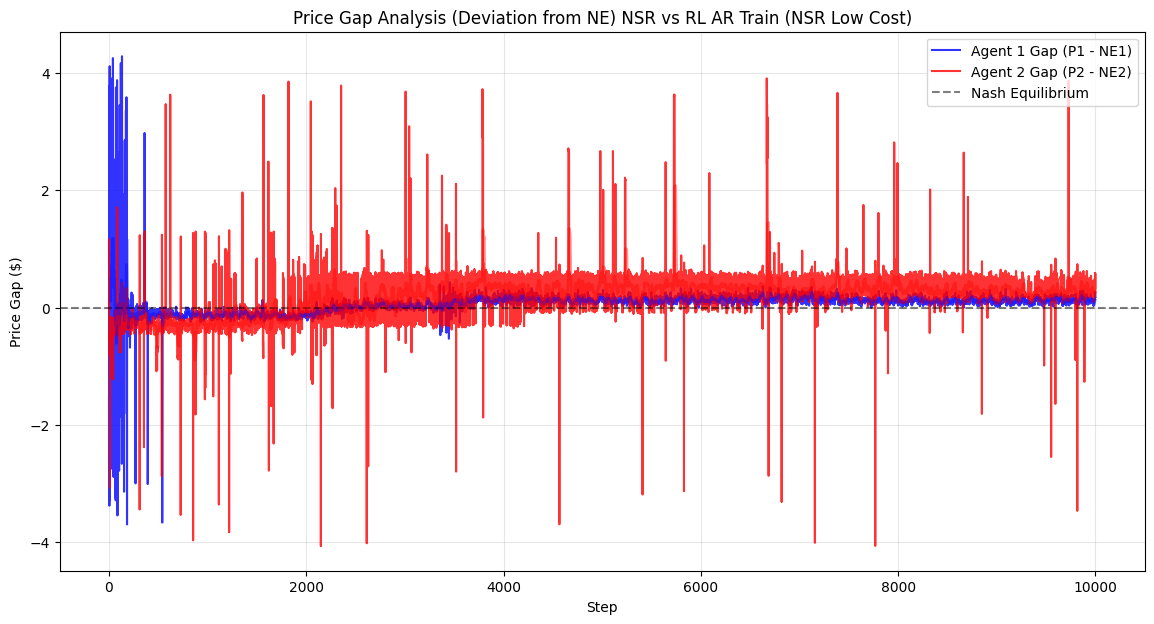

In [ ]:
plot_price_gap(rl_nsr_ar_tr, env_config, title_suffix="NSR vs RL AR Train (NSR Low Cost)")

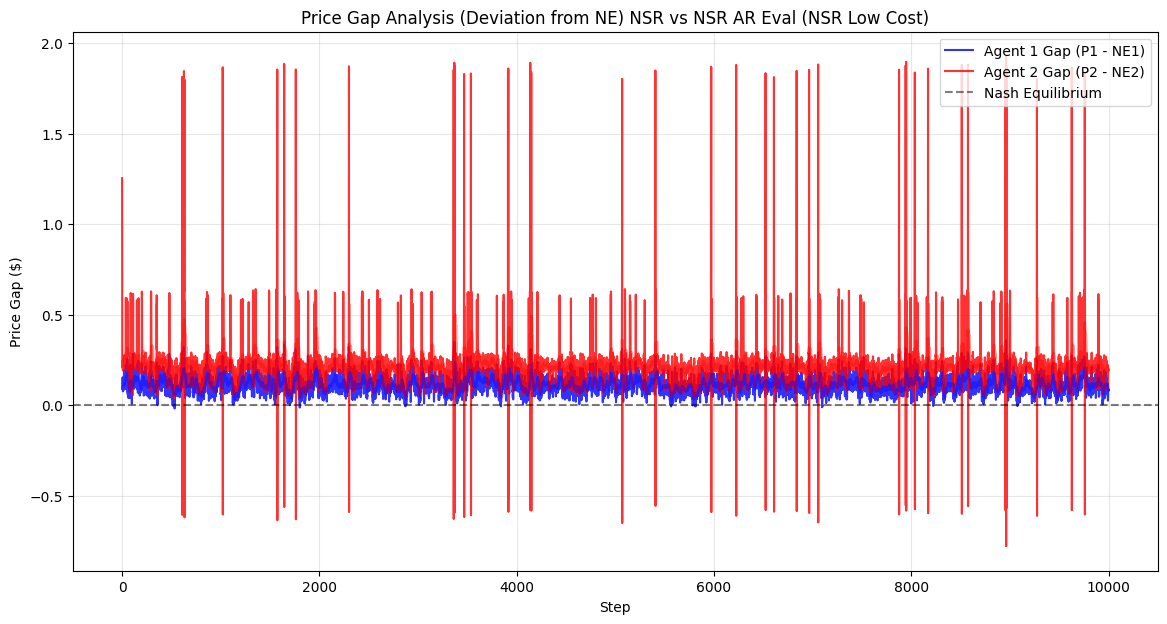

In [13]:
plot_price_gap(rl_nsr_ar_ts, env_config, title_suffix="NSR vs NSR AR Eval (NSR Low Cost)")

### RL vs NSR

### RL vs RL